## Entendiendo las puertas multi-qubit

Dos o más qubits pueden combinar sus estados mediante su **producto tensorial**, o a veces referido como el **producto de Kronecker**. Para mayor conveniencia, aquí se proporciona la representación del vector:

$$
|a\rangle \otimes |b\rangle = |ab\rangle
$$

Para dos qubits, específicamente, $$ |0\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix} $$ y $$ |1\rangle = \begin{pmatrix}0 \\ 1\end{pmatrix} $$, y sus amplitudes complejas $ v_0 $ y $ v_1 $, respectivamente, su producto tensorial se expresa de la siguiente manera:

$$
v_{00}|00\rangle + v_{01}|01\rangle + v_{10}|10\rangle + v_{11}|11\rangle = \begin{pmatrix} v_{00} \\ v_{01} \\ v_{10} \\ v_{11} \end{pmatrix} = |\psi\rangle
$$

El vector que resulta al aplicar el producto tensorial es el estado base de los dos qubits, $ |\psi\rangle $.

En esta sección, discutiremos las puertas multi-qubit y cómo operan sobre los qubits de manera similar a cómo lo hacen las puertas de un solo qubit, lo que incluye ser unitarias y reversibles. En la siguiente ecuación, una puerta multi-qubit, representada por una matriz $ U $, se multiplica por un vector de estado cuántico $ |\psi_0\rangle $ para producir el vector de estado cuántico resultante $ |\psi_2\rangle $:

$$
U|\psi_0\rangle = |\psi_2\rangle
$$

Para mantener las descripciones y los ejemplos uniformes, las siguientes descripciones de las puertas multi-qubit se presentarán de la misma manera que las puertas de un solo qubit. Crearemos una nueva función auxiliar similar a la que utilizamos anteriormente para los circuitos de un solo qubit. 

La función auxiliar tendrá algunas diferencias, la primera de las cuales será el **simulador** que usaremos para ejecutar los circuitos:


In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_state_qsphere

def execute_circuit(quantum_circuit, qubits, classical_bits):
    """
    Ejecuta un circuito cuántico en los simuladores QASM y de estado vectorial,
    obtiene los resultados, dibuja el circuito, genera un histograma de los resultados
    y una visualización de la QSphere.

    Args:
        quantum_circuit (QuantumCircuit): El circuito cuántico a ejecutar.
        qubits (list): Lista de qubits a medir.
        classical_bits (list): Lista de bits clásicos donde almacenar los resultados.

    Returns:
        tuple: Una tupla que contiene:
            - results (dict): Resultados del conteo de las mediciones (incluyendo ceros).
            - circuit_diagram (matplotlib.figure.Figure): Representación gráfica del circuito.
            - histogram (matplotlib.figure.Figure): Figura del histograma de los resultados.
            - qsphere (matplotlib.figure.Figure): Figura de la QSphere del estado cuántico.
    """
    # Crear el simulador QASM
    qasm_simulator = Aer.get_backend('qasm_simulator')
    
    # Agregar medidas al circuito
    for q, c in zip(qubits, classical_bits):
        quantum_circuit.measure(q, c)

    # Ejecutar el circuito en el simulador QASM
    job_qasm = qasm_simulator.run(quantum_circuit, shots=1024)
    result_qasm = job_qasm.result()
    
    # Obtener los resultados de las mediciones
    results = result_qasm.get_counts()

    # Completar los resultados con ceros
    num_bits = len(classical_bits)
    all_possible_outcomes = [f"{i:0{num_bits}b}" for i in range(2**num_bits)]
    for outcome in all_possible_outcomes:
        if outcome not in results:
            results[outcome] = 0
    
    # Dibujar el circuito
    circuit_diagram = quantum_circuit.draw(output='mpl')
    
    # Crear un histograma de los resultados
    histogram = plot_histogram(results, figsize=(10, 5))
    
    # Crear el simulador de estado vectorial para obtener el estado cuántico antes de las mediciones
    statevector_simulator = Aer.get_backend('statevector_simulator')
    circuit_no_measurements = quantum_circuit.copy()
    circuit_no_measurements.remove_final_measurements()  # Eliminar las mediciones para obtener el estado vectorial
    job_sv = statevector_simulator.run(circuit_no_measurements)
    result_sv = job_sv.result()

    # Obtener el estado vectorial
    statevector = result_sv.get_statevector()
    
    # Crear la visualización de la QSphere
    qsphere = plot_state_qsphere(statevector)
    
    # Retornar todos los resultados
    return results, circuit_diagram, histogram, qsphere


Cambiaremos de usar el simulador de vectores de estado al simulador Qasm. **Qasm**, abreviatura de **Quantum Assembly language** (pronunciado como *kazm*), es un lenguaje de programación utilizado para describir las funciones que conforman los circuitos y operaciones cuánticas. Es el lenguaje de programación sobre el cual se construye Qiskit como una biblioteca de Python.

El propósito de cambiar al simulador Qasm no es que no podamos usar el simulador de vectores de estado, sino principalmente para observar algunas de las características interesantes de nuestro circuito y las puertas. Para aquellos que deseen seguir usando el simulador de vectores de estado, no se preocupen. Habrá desafíos en la sección de **Preguntas**, al final de este notebook, que les permitirán utilizarlo.

Otra diferencia que notarás es que ya no utilizaremos el QSphere para visualizar los estados cuánticos. En su lugar, reemplazaremos la salida del QSphere con un histograma que muestra los conteos de los resultados. Para cada circuito que crearemos, incluiremos más de un qubit, ya que estas puertas multi-qubit operan sobre dos o más qubits.

Ahora que tenemos nuestra función auxiliar, ejecutémosla y pasemos al siguiente conjunto de puertas, las **puertas multi-qubit**. Estas incluyen:

- La puerta CNOT
- La puerta Toffoli
- La puerta Swap

Aprenderemos sobre estas puertas en las siguientes secciones.

### Aprendiendo sobre la puerta multi-qubit CNOT

La puerta **CNOT**, a menudo conocida como puerta de Control-NOT, es similar a la puerta XOR de los bits clásicos. La puerta CNOT se compone de dos partes.

La primera parte es el **Control**, que está conectado a uno de los qubits y es lo que desencadena que la puerta CNOT realice una operación en el otro qubit conectado al otro extremo de la puerta CNOT, el **Target**.

El **Target** es una operación que se realizará en el otro qubit; en este caso, es una operación NOT. Recordemos de la sección anterior sobre puertas de un solo qubit que la puerta NOT rota el qubit alrededor del eje **x** por $\pi /2$. La puerta CNOT es una de las puertas multi-qubit más utilizadas, ya que es la forma en que los qubits se entrelazan.

La puerta $CNOT$ también se describe como una puerta de Control-X (CX) ya que el target a menudo se codifica como una operación $X$. Verás esta convención de puerta CX al ejecutar el siguiente ejemplo. La representación matricial de una puerta CNOT es una matriz de 4x4 debido al producto tensorial de dos qubits, como se ilustra aquí:

$$
\text{CNOT} =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}
$$

***Nota*** que el cuadrante superior izquierdo de 2x2 de la matriz $CNOT$ representa una matriz de identidad, $I$, y el cuadrante inferior derecho de 2x2 representa la matriz $X$.

La siguiente tabla de verdad ilustra que cuando el qubit de control (el lado izquierdo del vector de entrada) es 0, no hay cambios en el qubit objetivo (el lado derecho del vector de entrada). Cuando el qubit de control está en 1, entonces la operación en el qubit objetivo está habilitada y, por lo tanto, rota el qubit objetivo alrededor del eje **x** por π (es decir, 180°):

<table>
  <tr>
    <th>Entrada</th>
    <th>Salida</th>
  </tr>
  <tr>
    <td>|00⟩</td>
    <td>|00⟩</td>
  </tr>
  <tr>
    <td>|01⟩</td>
    <td>|01⟩</td>
  </tr>
  <tr>
    <td>|10⟩</td>
    <td>|11⟩</td>
  </tr>
  <tr>
    <td>|11⟩</td>
    <td>|10⟩</td>
  </tr>
</table>

Ahora vamos a crear un circuito, agregar una puerta CNOT y ejecutarlo:

1. Comenzaremos creando un circuito cuántico de dos qubits y aplicando una puerta de Hadamard al primer qubit, y una puerta CNOT a los dos qubits, donde el Control se establece en el primer qubit y el Target se establece en el segundo qubit.




Resultados de las mediciones: {'11': 1024, '00': 0, '01': 0, '10': 0}

Diagrama del circuito:


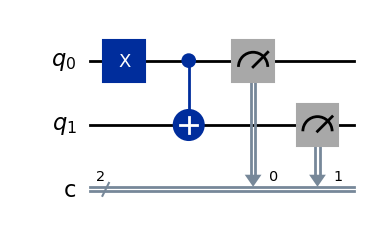

In [20]:
# Crear un circuito cuántico simple
qbits = QuantumRegister(2, 'q')
cbits = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qbits, cbits)
qc.x(0)  # Puerta Hadamard en el qubit 0
qc.cx(0, 1)  # Puerta CNOT con qubit 0 como control y qubit 1 como objetivo

# Ejecutar el circuito
results, circuit_diagram, histogram, qsphere = execute_circuit(qc, qbits, cbits)

# Mostrar los resultados
print("Resultados de las mediciones:", results)
print("\nDiagrama del circuito:")
circuit_diagram


2. Vamos a examinar el vector de estado 

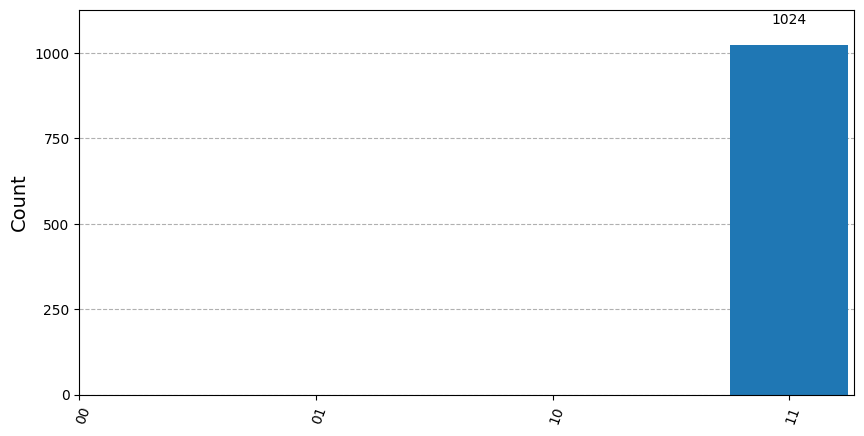

In [21]:
histogram

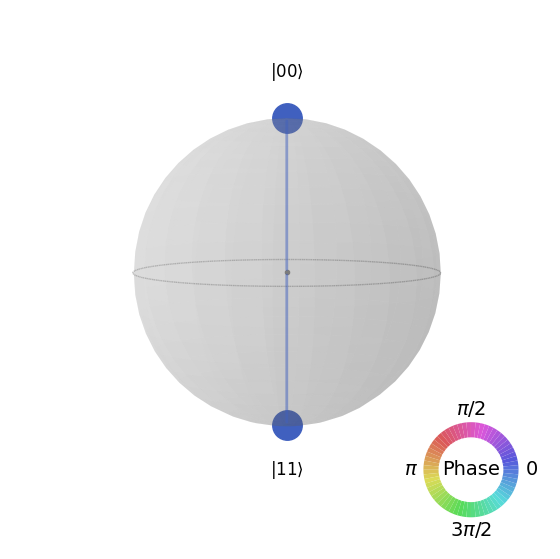

In [5]:
qsphere

Los resultados de las puertas anteriores son solo una pequeña muestra, como puedes observar en algunos de los qubits personalizados, como la puerta $ R_x $ o la puerta $CNOT$, que te permiten rotar cualquier estado en la QSphere para cada qubit.

Ahora veamos operadores que no son reversibles, pero que aún son cuánticos. No te preocupes, no estoy contradiciendo mi declaración anterior que requiere que los operadores cuánticos sean unitarios y, por lo tanto, reversibles.

En la siguiente sección, aclararé lo que esto significa. Existen otras puertas de Control que implementan otras operaciones, como las puertas de **Control-Y (CY)**, **Control-Z (CZ)**, **Control-H (CH)**, y más. Todas estas comparten las mismas características que la puerta **CNOT (CX)**, es decir, tienen una Fuente y un Objetivo. La principal diferencia, como puedes imaginar, es la operación que seguirá el Objetivo. Para la puerta CNOT, el Objetivo operaría con una puerta X y, naturalmente, una puerta de **Control-Y** operaría con una puerta Y sobre el qubit Objetivo. Prueba algunas por ti mismo y observa cómo difieren los resultados. Nota que las operaciones serán las mismas que si ejecutaras una sola puerta en el qubit Objetivo.

La última puerta multi-qubit en la que nos centraremos, y que también se usa en una variedad de algoritmos cuánticos, es la **puerta Toffoli**.

### Aplicación de la puerta Toffoli de múltiples qubits

La **puerta Toffoli** recibe su nombre de Tommaso Toffoli, un profesor italoamericano en computación e ingeniería eléctrica en la Universidad de Boston. Esta puerta es muy similar a las puertas de Control de múltiples qubits mencionadas anteriormente, solo que esta puerta tiene múltiples Controles y un único Objetivo. Para simplificar la descripción de puertas de control múltiple, se representan con las notaciones **CCX** para una puerta de Control-Not de doble control, y **CCCX** para una puerta de Control-Not de triple control.

La representación general de la matriz de la puerta Toffoli es una matriz de **8 x 8** debido al producto tensorial de tres qubits, como se ilustra en la siguiente matriz. Nota que las tres primeras submatrices diagonales **2 x 2** son matrices Identidad y la última submatriz **2 x 2** (esquina inferior derecha) representa una puerta NOT que invierte el qubit. Nota que la matriz de la puerta Toffoli en Qiskit es ligeramente diferente, pero produce los mismos resultados:

$$
\text{Toffoli} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$$

Vamos a ejecutar esta puerta para ver los resultados en nuestro circuito cuántico:

1. Comenzaremos creando un circuito cuántico de tres qubits y aplicando una puerta **CCX (Toffoli)**, donde los dos primeros qubits son los qubits de control y el tercer qubit es el qubit objetivo.




In [6]:
# Compuerta CCX
from math import pi

# Crear un circuito cuántico de 3 qubits y 3 bits clásicos
qbits = QuantumRegister(3, 'q')
cbits = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qbits, cbits)

qc.h(0)  # Aplicar una compuerta Hadamard al qubit 0
qc.x(0)  # Aplicar una compuerta X al qubit 0

# Aplicar una compuerta CCX
qc.ccx(0, 1, 2)

# Ejecutar el circuito
results, circuit_diagram, histogram, qsphere = execute_circuit(qc, qbits, cbits)
results

{'001': 517,
 '000': 507,
 '010': 0,
 '011': 0,
 '100': 0,
 '101': 0,
 '110': 0,
 '111': 0}

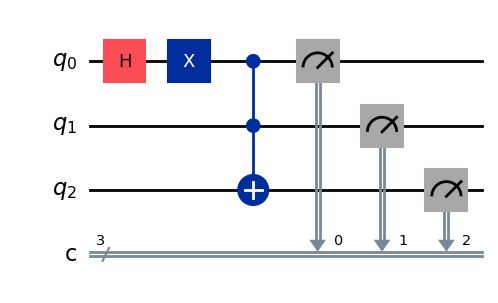

In [7]:
circuit_diagram

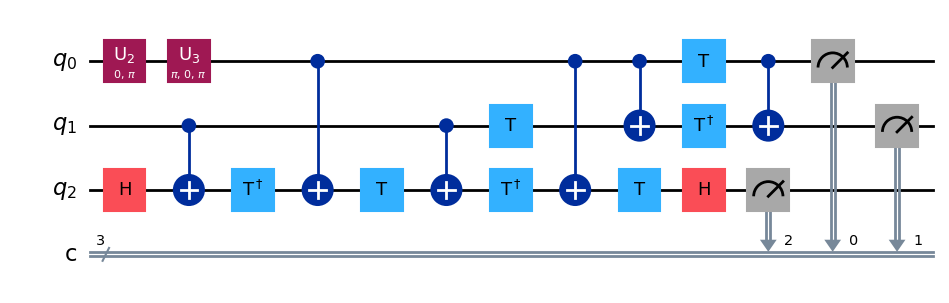

In [8]:
qc.decompose().draw(output='mpl')

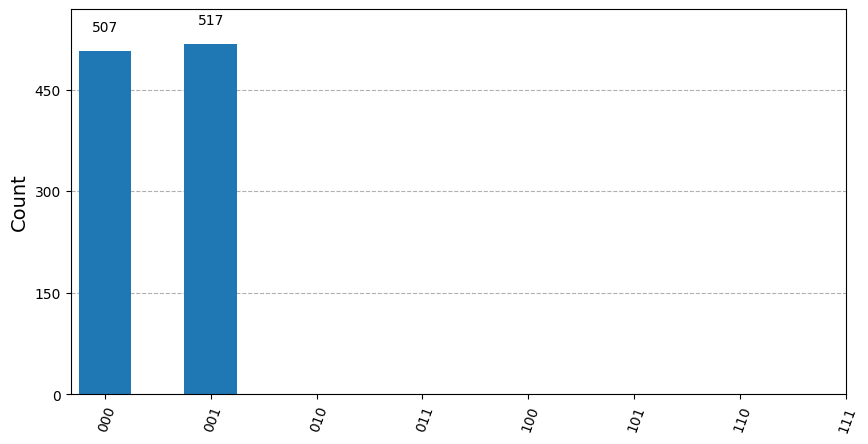

In [9]:
histogram

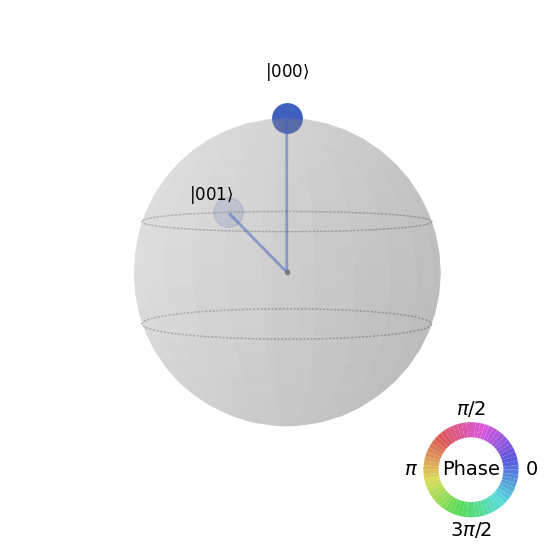

In [10]:
qsphere

Es innecesario decir que esto parece muy complicado. Puedes observar que el uso de varias puertas de un solo qubit y de múltiples qubits para representar esta única puerta es bastante complejo. Si esto se ejecuta en un dispositivo a corto plazo con qubits de baja coherencia, seguramente se observarán algunos efectos relacionados con el ruido. En este ejemplo, puedes ver el uso de las puertas **H**, **CNOT** y **T†**. Existen otras puertas de múltiples qubits que aprovechan estas operaciones.

Veamos una puerta que usaríamos para intercambiar información entre un qubit y otro.

### Usando la puerta Swap en un circuito
La **puerta swap** se utiliza para intercambiar los valores de dos qubits. La representación matricial de la puerta swap se define como:

$$
\text{SWAP} =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

### Creemos un circuito e implementemos esto intercambiando dos qubits:
1. Configuraremos el primer qubit en el estado $|0\rangle$ y el segundo qubit en el estado $|1\rangle$. Luego, invocaremos un intercambio entre los dos usando la puerta swap y verificaremos los resultados de cada qubit.


In [11]:

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.x(qreg_q[1])
circuit.swap(qreg_q[0], qreg_q[1])

# Aplicar una compuerta SWAP
#qc.swap(0, 1)

results, circuit_diagram, histogram, qsphere = execute_circuit(circuit, qreg_q, creg_c)   
results

{'01': 1024, '00': 0, '10': 0, '11': 0}

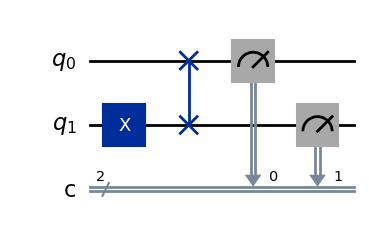

In [12]:
circuit_diagram


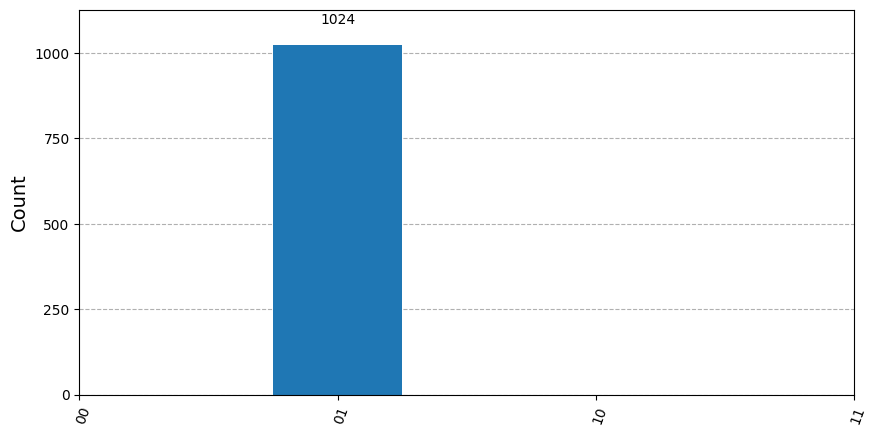

In [13]:
histogram

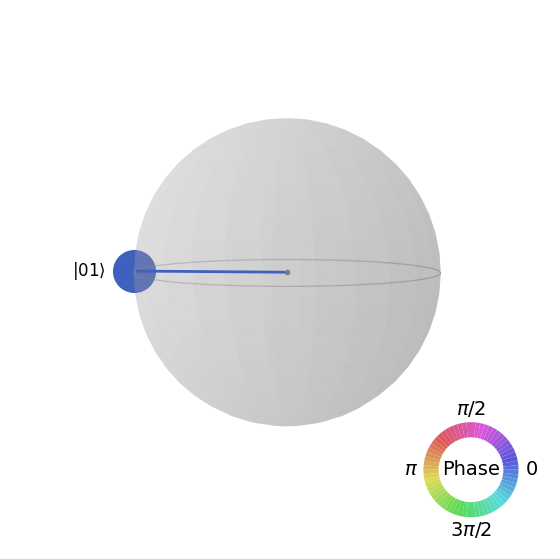

In [14]:
qsphere

## Comprendiendo los operadores no reversibles

Un **operador no reversible** se refiere a que, si aplicamos este operador en uno o más qubits y luego lo volvemos a aplicar en los mismos qubits, el resultado no devolverá los qubits al estado que tenían antes de aplicar el operador.

Esta sección cubre los operadores no reversibles y las razones por las cuales son tan importantes como los otros operadores discutidos previamente.

### Medición
La **medición** es un operador que instruye al sistema cuántico para medir el estado cuántico del sistema. Antes de profundizar en cómo incluimos la instrucción de medición en nuestros circuitos cuánticos, definamos qué significa medir el estado cuántico del sistema.

Sabemos, a partir de la mecánica cuántica, que la información sobre un sistema cuántico es imposible de acceder completamente, específicamente la medición de las amplitudes complejas del qubit. Por ejemplo, supongamos que tenemos un qubit en un estado de superposición $|\psi\rangle$, donde las amplitudes complejas suman 1:

$$
\sum_{j=0}^{k-1} |\alpha_j|^2 = 1
$$

Una medición de lo anterior no puede proporcionar información sobre las amplitudes complejas en \(\alpha\), debido a las restricciones de los principios de la mecánica cuántica. En su lugar, lo que la medición de un qubit devuelve es la base $|j\rangle$ con una probabilidad $|\alpha_j|^2$ del estado $|\psi\rangle$ en la base estándar.

Hemos visto un ejemplo de esto antes al describir la puerta de Hadamard. Cuando configuramos el qubit en una combinación lineal compleja de $\alpha|0\rangle$ y $\beta|1\rangle$, donde $\alpha$ y $\beta$ son las amplitudes complejas de los estados base, el resultado de la medición se basa en la probabilidad $|\alpha|^2$ de medir $|0\rangle$ y $|\beta|^2$ de medir $|1\rangle$, lo que para una puerta de Hadamard resulta en un 50% de $|1/\sqrt{2}|^2$.

Si intentaras medir nuevamente, el resultado sería el mismo que en la primera medición. Por lo tanto, la medición es un operador **no reversible**, ya que si lo aplicas de nuevo, no producirá el estado cuántico que el qubit tenía antes de la medición.

Una vez que se completa la medición, el resultado se envía al bit clásico que devolverá la información al sistema clásico. Ahora que entendemos cómo funciona la medición y cuáles son los resultados de las mediciones, ¡veamos un ejemplo en acción!

En este ejemplo, crearemos un circuito simple de dos qubits que incluye una puerta de Hadamard y una puerta CNOT:
1. Primero, agregaremos la función de medición al final del circuito, que mapeará automáticamente los resultados de medir los qubits a sus respectivos bits clásicos. También agregaremos puertas de Hadamard y CNOT.
2. Luego, visualizaremos nuestros resultados ingresando los comandos correspondientes.



In [15]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

# Aplicar una compuerta H al qubit 0
circuit.h(qreg_q[0])

# Aplicar una compuerta CNOT con qubit 0 como control y qubit 1 como objetivo
circuit.cx(qreg_q[0], qreg_q[1])

results, circuit_diagram, histogram, qsphere = execute_circuit(circuit, qreg_q, creg_c)

In [16]:
results

{'11': 507, '00': 517, '01': 0, '10': 0}

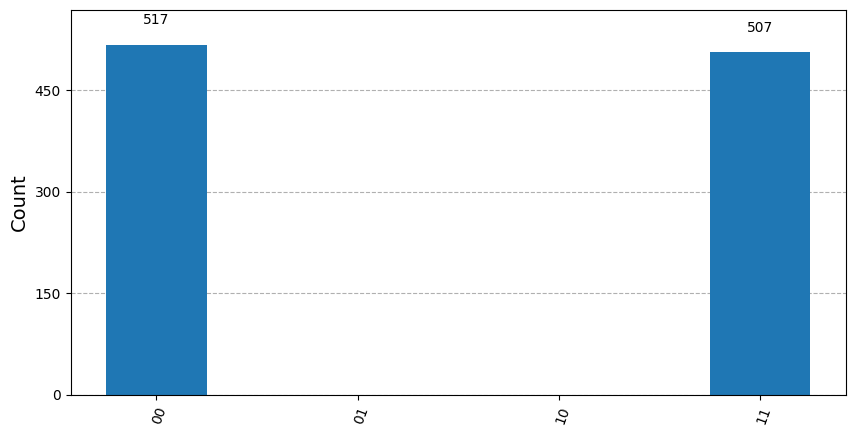

In [17]:
histogram

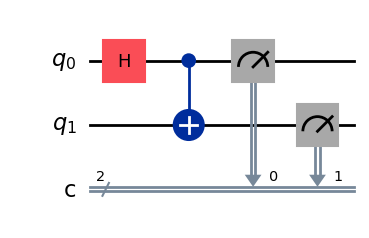

In [18]:
circuit_diagram

# Preguntas

1. Para las puertas de múltiples qubits, intenta intercambiar la Fuente y el Objetivo. ¿Ves alguna diferencia cuando descompones el circuito?

2. Descompón todas las puertas para circuitos de un solo qubit y de múltiples qubits. ¿Qué notas acerca de cómo se construyen las puertas universales?

3. Implementa la puerta Toffoli donde el objetivo sea el qubit central de un circuito de tres qubits.

4. Descompón la puerta Toffoli. ¿Cuántas puertas en total se utilizan para construirla?

5. Aplica la puerta Toffoli junto con una puerta de Hadamard a un simulador de vector de estado y compara los resultados con los del simulador Qasm. ¿Qué diferencias ves y por qué?

6. Si quisieras ordenar tres qubits en la dirección opuesta, ¿qué puertas usarías y en qué orden?

7. Dado un circuito de tres qubits, ¿cómo intercambiarías el primer y el tercer qubit?

8. Dado un circuito de tres qubits, ¿cómo configurarías el segundo qubit como el Objetivo de una puerta Toffoli?
